## ResNet152 With pytorch
The architeccture of this will be provided in the documentation
For now we need to under stand the main things we need 
The choices of these tools are decided upon by the group members.

a. Model Compilation:

    Specify the optimizer (e.g., Adam), loss function (e.g., binary cross-entropy), and evaluation metrics (e.g., accuracy).

b. Training:

    Train the compiled model using the data generators.
    Provide code snippets for training the model using the Keras fit() function.

c. Performance Evaluation:

    Evaluate the trained model on the validation data.
    Specify the metrics used for evaluation (e.g., accuracy, precision, recall, ROC curves).

e. Results Analysis:

    Analyze the model's performance and make any necessary adjustments or improvements based on the results.

In [4]:
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report as skl_classification_report


# Create csv for easy loading

In [5]:

def create_csv(data_dir, output_file):
    classes = ['Normal', 'Cataract']
    data = []

    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Load image into memory to check if it's valid
                with Image.open(img_path) as img:
                    img.verify()  # Verify that the file is an image
                data.append([img_path, class_id])
            except (IOError, SyntaxError) as e:
                print(f"Image {img_path} is corrupted or unreadable. Assigning default label.")
                # Assign a default label if the image is corrupted/unreadable
                data.append([img_path, -1])  # Assuming -1 as a default label for corrupted images

    df = pd.DataFrame(data, columns=['img_path', 'label'])
    df.to_csv(output_file, index=False)

train_dir = "../data/train"
test_dir = "../data/test"
test2_dir = "../data/test2"

# Create CSV files for training and testing datasets
create_csv(train_dir, 'train.csv')
create_csv(test_dir, 'test.csv')
create_csv(test2_dir, 'test2.csv')

Image ../data/train/Normal/.ipynb_checkpoints is corrupted or unreadable. Assigning default label.


# Reading and Exploring the Data


Train size = 1983
Test size = 1001
                              img_path  label
0  ../data/train/Normal/cat_0_8796.jpg      0
1  ../data/train/Normal/cat_0_8730.jpg      0
2  ../data/train/Normal/cat_0_9516.jpg      0
3  ../data/train/Normal/cat_0_9506.jpg      0
4  ../data/train/Normal/cat_0_8809.jpg      0
                             img_path  label
0  ../data/test/Normal/cat_0_1069.jpg      0
1  ../data/test/Normal/cat_0_1537.jpg      0
2  ../data/test/Normal/cat_0_1291.jpg      0
3   ../data/test/Normal/cat_0_961.jpg      0
4  ../data/test/Normal/cat_0_1367.jpg      0
Number of missing labels in the training set: 0
Number of missing labels in the training set after filling: 0


/tmp/ipykernel_140602/2343744922.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), alpha=0.8, palette='bright')


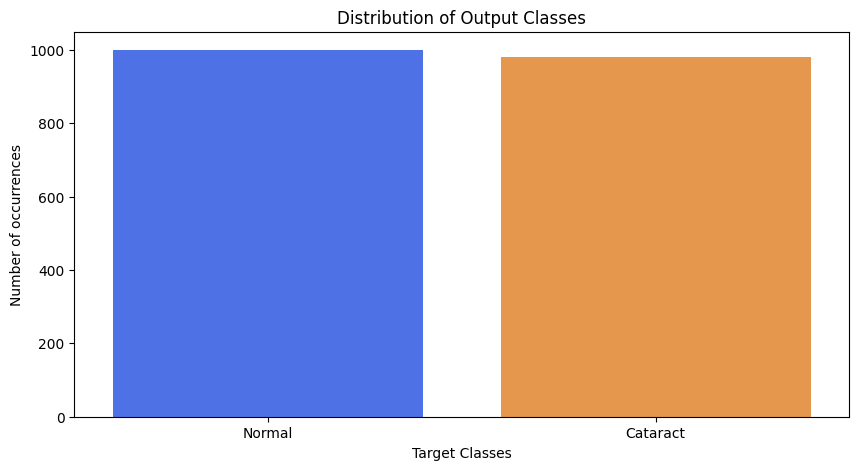

In [10]:
# # Load CSV files
# train_csv = pd.read_csv('train.csv')
# test_csv = pd.read_csv('test.csv')

# # Print lengths of CSV files
# print('Train size = {}'.format(len(train_csv)))
# print('Test size = {}'.format(len(test_csv)))

# # Display initial values
# print(train_csv.head())
# print("========================================")
# print(test_csv.head())

# # Check for missing labels
# missing_labels = train_csv['label'].isnull().sum()
# print(f"Number of missing labels in the training set: {missing_labels}")

# # Assign a default label to missing labels (assuming default label is 0 for 'Normal')
# default_label = 0  
# train_csv['label'].fillna(default_label, inplace=True)

# # Verify that there are no more missing labels
# missing_labels_after = train_csv['label'].isnull().sum()
# print(f"Number of missing labels in the training set after filling: {missing_labels_after}")

# # Distribution of output classes
# counts = train_csv['label'].value_counts()
# class_list = ['Normal', 'Cataract']
# counts = {class_list[i]: counts.get(i, 0) for i in range(len(class_list))}

# plt.figure(figsize=(10, 5))
# sns.barplot(x=list(counts.keys()), y=list(counts.values()), alpha=0.8, palette='bright')
# plt.title('Distribution of Output Classes')
# plt.ylabel('Number of occurrences')
# plt.xlabel('Target Classes')
# plt.show()


# Load CSV files
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

# Print lengths of CSV files
print('Train size = {}'.format(len(train_csv)))
print('Test size = {}'.format(len(test_csv)))

# Display initial values
print(train_csv.head())
print("========================================")
print(test_csv.head())

# Check for missing labels
missing_labels = train_csv['label'].isnull().sum()
print(f"Number of missing labels in the training set: {missing_labels}")

# Assign a default label to missing labels (assuming default label is 0 for 'Normal')
default_label = 0  
train_csv.loc[train_csv['label'].isnull(), 'label'] = default_label

# Verify that there are no more missing labels
missing_labels_after = train_csv['label'].isnull().sum()
print(f"Number of missing labels in the training set after filling: {missing_labels_after}")

# Distribution of output classes
counts = train_csv['label'].value_counts()
class_list = ['Normal', 'Cataract']
counts = {class_list[i]: counts.get(i, 0) for i in range(len(class_list))}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of occurrences')
plt.xlabel('Target Classes')
plt.show()


# Visualizing the Data


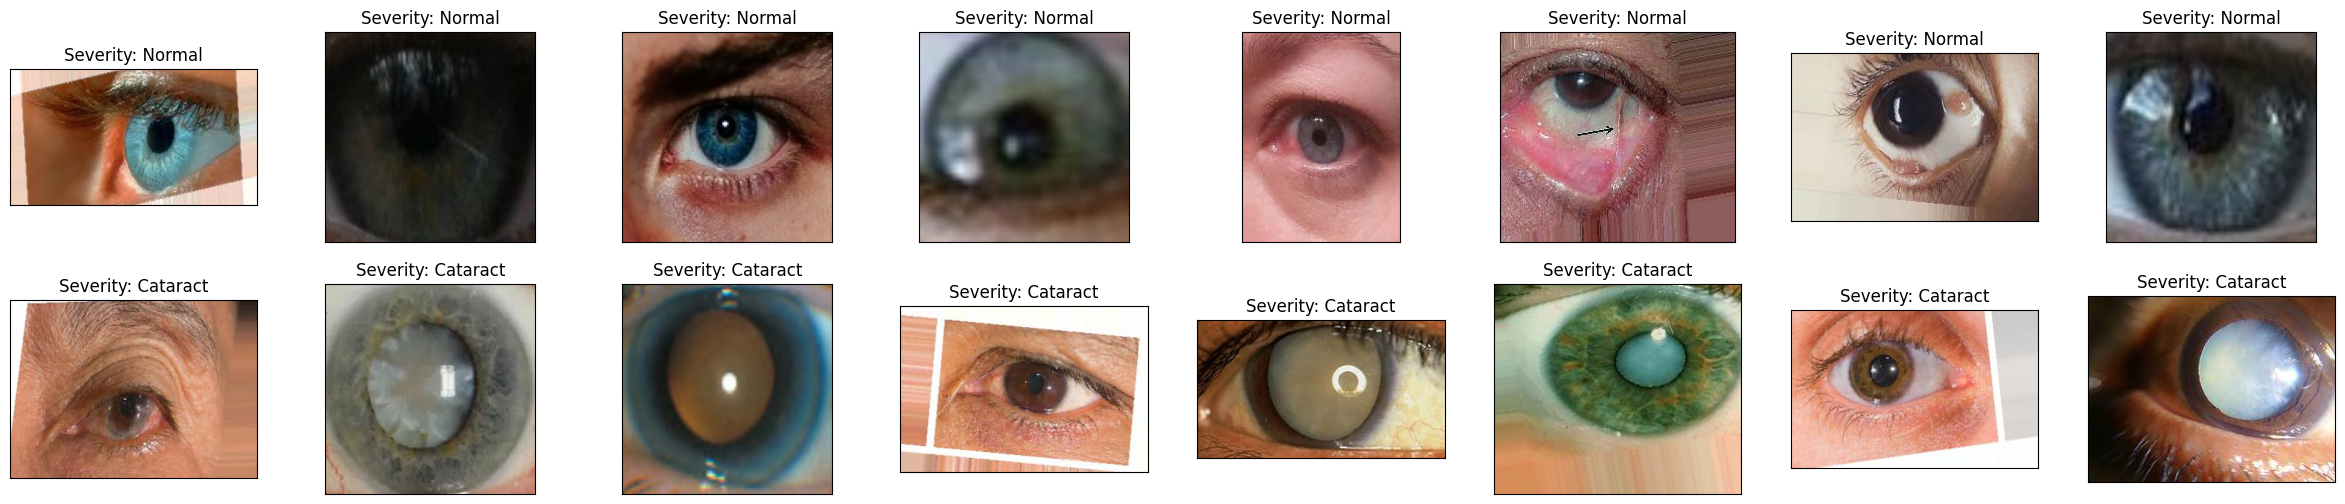

In [11]:
base_dir = '../data'

fig = plt.figure(figsize=(30, 6))

train_normal_dir = os.path.join(base_dir, 'train', 'Normal')
train_cataract_dir = os.path.join(base_dir, 'train', 'Cataract')

train_normal_imgs = os.listdir(train_normal_dir)
train_cataract_imgs = os.listdir(train_cataract_dir)

for idx, img in enumerate(np.random.choice(train_normal_imgs, 8)):
    ax = fig.add_subplot(2, 8, idx + 1, xticks=[], yticks=[])
    im = Image.open(os.path.join(train_normal_dir, img))
    plt.imshow(im)
    ax.set_title('Severity: Normal')

for idx, img in enumerate(np.random.choice(train_cataract_imgs, 8)):
    ax = fig.add_subplot(2, 8, idx + 9, xticks=[], yticks=[])
    im = Image.open(os.path.join(train_cataract_dir, img))
    plt.imshow(im)
    ax.set_title('Severity: Cataract')

plt.show()

# Data Processing

In [35]:
# class CreateDataset(Dataset):
#     def __init__(self, df_data, data_dir='../data', transform=None):
#         super().__init__()
#         self.df = df_data.values
#         self.data_dir = data_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         img_name, label = self.df[index]
#         img_path = os.path.join(img_name)
#         image = cv2.imread(img_path)

#         if image is None:
#             print(f"Warning: Image at path {img_path} could not be read. Using a blank image.")
#             image = np.zeros((224, 224, 3), dtype=np.uint8)  # Use a blank image if the original cannot be read
#         else:
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if self.transform is not None:
#             image = self.transform(image)

#         return image, label
# Custom Dataset Class
class CataractDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self.data):
            # Return placeholder data when index is out of bounds
            return self.get_placeholder_data()
        
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert('RGB')
            label = int(self.data.iloc[idx, 1])
            if label not in [0, 1]:
                raise ValueError("Invalid label")
        except Exception as e:
            print(f"Warning: {e}. Using a blank image.")
            image = Image.new('RGB', (224, 224))
            label = 0  # Default label for blank image

        if self.transform:
            image = self.transform(image)

        return image, label
    def get_placeholder_data(self):
        # Return a blank image and a default label
        blank_image = Image.new('RGB', (224, 224), color='white')
        default_label = 0  # Default label
        if self.transform:
            blank_image = self.transform(blank_image)
        return blank_image, default_label


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_path = '../data/train/'
test_path = '../data/test/'

# train_data = CataractDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
# test_data = CataractDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

# Create Dataset and DataLoader
train_dataset = CataractDataset(csv_file='train.csv', root_dir='../train', transform=train_transforms)
test_dataset = CataractDataset(csv_file='test.csv', root_dir='../test', transform=test_transforms)


valid_size = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# trainloader = DataLoader(train_data, batch_size=4, sampler=train_sampler)
# validloader = DataLoader(train_data, batch_size=4, sampler=valid_sampler)
# testloader = DataLoader(test_data, batch_size=4)

trainloader = DataLoader(train_dataset, batch_size=4,sampler=train_sampler )
validloader = DataLoader(test_dataset, batch_size=4, sampler=valid_sampler)


print(f'Training examples: {len(train_dataset)}')
print(f'Testing examples: {len(test_dataset)}')

# Print the length of the dataset
print(f"Length of the training dataset: {len(train_dataset)}")
print(f"Length of the test dataset: {len(test_dataset)}")

 #Check a batch of data from the DataLoader
images, labels = next(iter(trainloader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels: {labels}")



Training examples: 1983
Testing examples: 1001
Length of the training dataset: 1983
Length of the test dataset: 1001
Batch of images shape: torch.Size([4, 3, 224, 224])
Batch of labels: tensor([1, 1, 1, 1])


# Visualizing the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Image shape: torch.Size([4, 3, 224, 224])
Label shape: torch.Size([4])
Labels: tensor([0, 1, 1, 1])


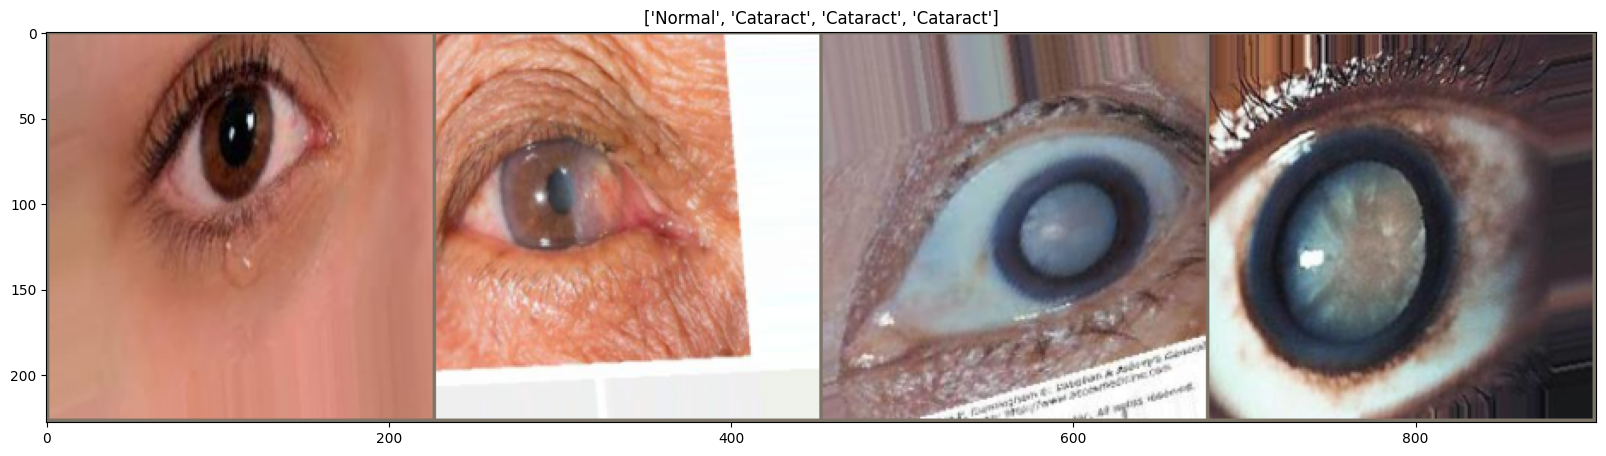

In [36]:
# Function to denormalize and display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Clipping the values to be in the valid range [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Load one batch of the training set
images, labels = next(iter(trainloader))

# Checking the shape of the image
print(f'Image shape: {images.shape}')
print(f'Label shape: {labels.shape}')

# Plotting the images of loaded batch with given fig size and frame data
grid = torchvision.utils.make_grid(images, nrow=4, padding=2)
plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
print('Labels:', labels)

class_names = ['Normal', 'Cataract']
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

# Show the plot
plt.show()

# Training and Validation

/home/thembo/college/cataract/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thembo/college/cataract/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is unfrozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen
Number of trainable parameters: 
18354690
Model Training started......
Epoch 1 Batch 1 Labels: tensor([0, 0, 1, 1])
Epoch 1 Batch 2 Labels: tensor([1, 0, 0, 0])
Epoch 1 Batch 3 Labels: tensor([1, 1, 0, 1])
Epoch 1 Batch 4 Labels: tensor([0, 1, 1, 1])
Epoch 1 Batch 5 Labels: tensor([1, 1, 1, 0])
Epoch 1 Batch 6 Labels: tensor([1, 1, 1, 0])
Epoch 1 Batch 7 Labels: tensor([0, 1, 1, 0])
Epoch 1 Batch 8 Labels: tensor([1, 1, 1, 1])
Epoch 1 Batch 9 Labels: tensor([1, 0, 0, 0])
Epoch 1 Batch 10 Labels: tensor([0, 0, 0, 0])
Epoch 1 Batch 10 complete
Epoch 1 Batch 11 Labels: tensor([1, 1, 0, 0])
Epoch 1 Batch 12 Labels: tensor([1, 0, 1, 0])
Epoch 1 Batch 13 Labels: tensor([1, 0, 1, 1])
Epoch 1 Batch 14 Labels: tensor([1, 0, 0, 1])
Epoch 1 Batch 15 Labels: tensor([0, 0, 0, 1])
Epoch 1 Batch 16 Labels: tensor([0, 0, 1, 1])
Epoch 1 

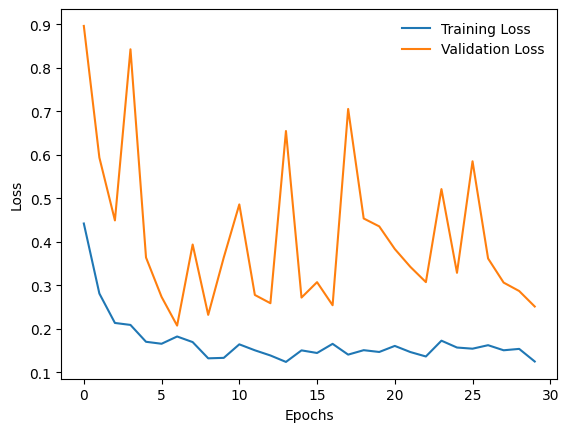

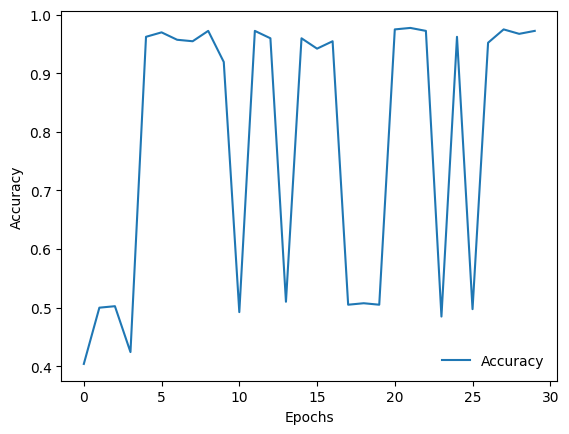

In [37]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
model = models.resnet152(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
out_ftrs = 2  # Binary classification
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Linear(512, out_ftrs), nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

model.to(device)

# Unfreeze more layers for fine-tuning
for name, child in model.named_children():
    if name in ['layer2', 'layer4', 'fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

def load_model(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))


def train_and_test(e, model_save_path):
    epochs = e
    train_losses, valid_losses, acc = [], [], []
    valid_loss_min = np.inf
    model.train()
    print("Model Training started......")
    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            # Debugging: Print labels to check if any are set to -1
            print(f'Epoch {epoch + 1} Batch {batch + 1} Labels: {labels}')
            
            # Ensure labels are in the correct range
            if (labels < 0).any() or (labels > 1).any():
                raise ValueError(f'Invalid label detected: {labels}')

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} complete')

        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            print(f'Validation started for epoch {epoch + 1}')
            model.eval()
            for images, labels in validloader:
                # Debugging: Print labels to check if any are set to -1
                print(f'Epoch {epoch + 1} Validation Batch Labels: {labels}')

                # Ensure labels are in the correct range
                if (labels < 0).any() or (labels > 1).any():
                    raise ValueError(f'Invalid label detected: {labels}')

                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        valid_losses.append(test_loss / len(validloader))
        acc.append(accuracy / len(validloader))
        scheduler.step()
        print(f'Epoch: {epoch + 1}/{epochs}.. Training Loss: {running_loss / len(trainloader):.3f}.. Validation Loss: {test_loss / len(validloader):.3f}.. Validation Accuracy: {accuracy / len(validloader):.3f}')

        model.train()
        if test_loss / len(validloader) <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {test_loss / len(validloader):.6f}). Saving model...')
            torch.save({
                'epoch': epoch,
                'model': model,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss_min
            }, model_save_path)
            valid_loss_min = test_loss / len(validloader)

    print('Training completed successfully!')
    torch.save(model.state_dict(), 'final_model.pth')
    return train_losses, valid_losses, acc

train_losses, valid_losses, acc = train_and_test(30, 'model_checkpoint.pth')


# Plot the graph for epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

# Plot another graph for accuracy
plt.plot(acc, label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()


In [2]:
# Loading the model for inference
model.load_state_dict(torch.load('final_model.pth'))

def print_classification_report(model, testloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    report = skl_classification_report(true_labels, pred_labels, target_names=['Normal', 'Cataract'])
    print(report)

print_classification_report(model, testloader)


NameError: name 'model' is not defined

In [5]:
model_save_path = './classifier_with_metadata.pt'
torch.save({
    'epoch': 30,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'valid_losses': valid_losses,
    'acc': acc
}, model_save_path)
print(f'Model with metadata saved to {model_save_path}')


NameError: name 'optimizer' is not defined

In [3]:
# Load the saved state dict
saved_state_dict = torch.load('classifier.pt')

# Get the current model state dict
current_state_dict = model.state_dict()

# Print keys to compare
print("Saved state dict keys:")
print(saved_state_dict.keys())
print("\nCurrent model state dict keys:")
print(current_state_dict.keys())


NameError: name 'model' is not defined